# Time Series Analysis with ARIMA
**ARIMA ("Auto-Regressive Integrated Moving Average")** is a model used for forecasting future values based solely on the trends a feature follows over time. The ARIMA model is essentially three separate processes: AR, I, & MA. The AR or Auto-Regression deals with how past values influence future values. MA or Moving Average deals with the volatility of errors away from the mean to predict future values. I or Integration does not actually involved calculus, but rather it is a way remove overall upward or downward trends from the data to promote stationarity. For this particular example the ARIMA module is used without Integration making it an ARMA model where Integration is set to zero.

# What's Covered in this Notebook?
This notebook will cover how to implement the models using the statsmodels library, how to test for stationarity with the Dickey-Fuller test, how to determine the order of the model using ACF & PACF charts, as well as how to remove seasonality from a model by taking the first-difference.

**Summary:**
* Using Statsmodels for Time-Series
* Testing for Stationarity with ADFuller (Dickey-Fuller)
* Determining the model order with ACF and PACF
* Removing Upward/Downward sloping trends
* Removing Seasonality
* Using AIC/BIC for model selection


In [32]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

In [2]:
#ignoring statsmodel warning for ARIMA freq parameter
import warnings
warnings.filterwarnings('ignore')

# ARIMA with Ice Cream
<img src='images/ice_cream.jpg' width='150' height='150' style='float: right'>

Original notebook data and model implementation from https://github.com/ritvikmath/Time-Series-Analysis with accompanying YouTube video at [ritvikmath](https://www.youtube.com/watch?v=JCKMV0Cuk0k). This notebook is a compilation of many of the topics discussed within the accompanying times-series playlist. The toy dataset comes directly from the original repo. 

In [3]:
ice_cream = pd.read_csv('data/ice_cream.csv')

In [4]:
ice_cream.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [5]:
ice_cream.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)
ice_cream['date'] = pd.to_datetime(ice_cream.date)
ice_cream.set_index('date', inplace=True)
start_date = pd.to_datetime('2010-01-01')
ice_cream = ice_cream[start_date:]

In [6]:
#limiting years to the range from 2010 to 2020
ice_cream.head()

,production
date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


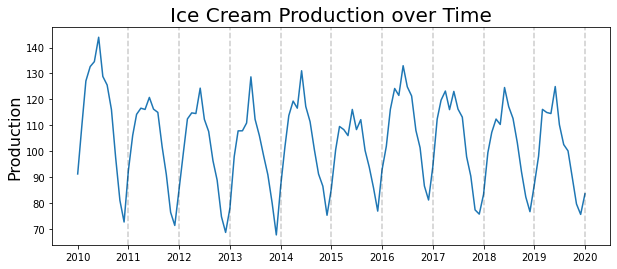

In [7]:
plt.figure(figsize=(10,4))
plt.plot(ice_cream.production)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Production')

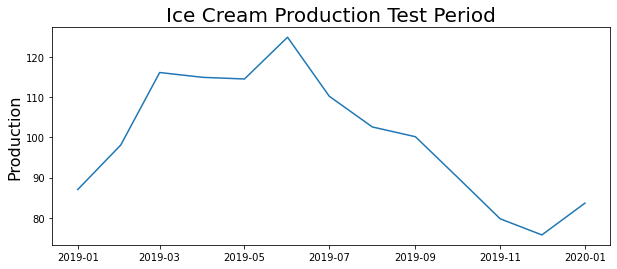

In [8]:
#Testing will be on the last 2-3 months of data in 2019
start_date = pd.to_datetime('2019-01-01')
end_date = pd.to_datetime('2020-01-01')
ice_cream_test = ice_cream[start_date:end_date]

plt.figure(figsize=(10,4))
plt.plot(ice_cream_test.production)
plt.title('Ice Cream Production Test Period', fontsize=20)
plt.ylabel('Production', fontsize=16)

# Stationarity & The Dickey-Fuller Test
Stationarity deals with how consistent a time-series remains with respect to time. A stationary time-series should not see any significant spikes or upward/downward trends but rather stable cycles that don't see significant changes through time.

To properly apply ARIMA models the time-series needs to be stable. To objectively check for stationarity we use the **Augmented Dickey-Fuller test** (adfuller) which can be imported from the statsmodels library. **If the p-value is below 0.05 the time-series is significantly stationary**. The adfuller test checks for unit roots within the time-series which cause problems with statistical inference.

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
#function created for easier interpretation of adfuller results
def adf_test(series):
    results = adfuller(series)
    print(f'ADF Statistic: {results[0]}')
    print(f'P-Value: {results[1]}')

In [11]:
adf_test(ice_cream)

ADF Statistic: -3.469206803861137
P-Value: 0.008814055324487216


# ACF & PACF
To determine which order model to use we can take a look at the ACF and PACF charts. Generally speaking, points above the error-band within the graph are likely to be significant in determining future values. ACF is usually a great way to determine the order of the Moving Average. PACF is a great way to determine the order of the Auto-Regression aspect of the trend.

### ACF

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

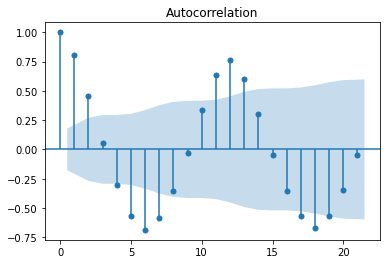

In [13]:
plot_acf(ice_cream)
plt.show()

### Interpreting the ACF Plot
The ACF plot will assist us in determining a value for the order of MA (also known as 'q'). Given the plot shown above the blue band is the increasing level of uncertainty over time and the spikes that peak above the band are potentially significant lags for a Moving Average model. We can see that at lags 2, 7, 13, & 18 we have a few contenders for our MA side of the model as they are above the blue band just before the spikes dip back into the blue area.

### PACF

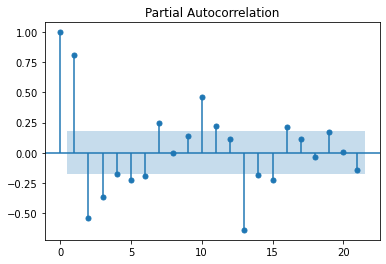

In [14]:
plot_pacf(ice_cream)
plt.show()

### Interpreting the PACF Plot
The PACF plot will assist us in determining a value for the order of AR (also known as 'p'). Similar to the blue band on our ACF plot points inside of the blue are considered insignificant whereas the spikes above the band are of particular interest. For this plot we will try a model with 'p' of 1,2,7,10,& 13.




# Model Selection
For the following section we will go through AR and MA orders respectively to see how each model fares independent of one another. Then, we will see if a combination of the two best models in AR & MA will perform better through ARIMA.

<img src='images/selection.jpg' width='400'>

# AIC & BIC
The way we will determine if a model does better than another is by comparing the AIC and BIC. The AIC will tell us generally if a model if performing better when that model has a lesser value of AIC than the other. So an AIC of 700 is better than an AIC of 800. BIC is similar to AIC in that we want a smaller value but BIC will also inform us if the model is closer to the true hidden function behind the data. 

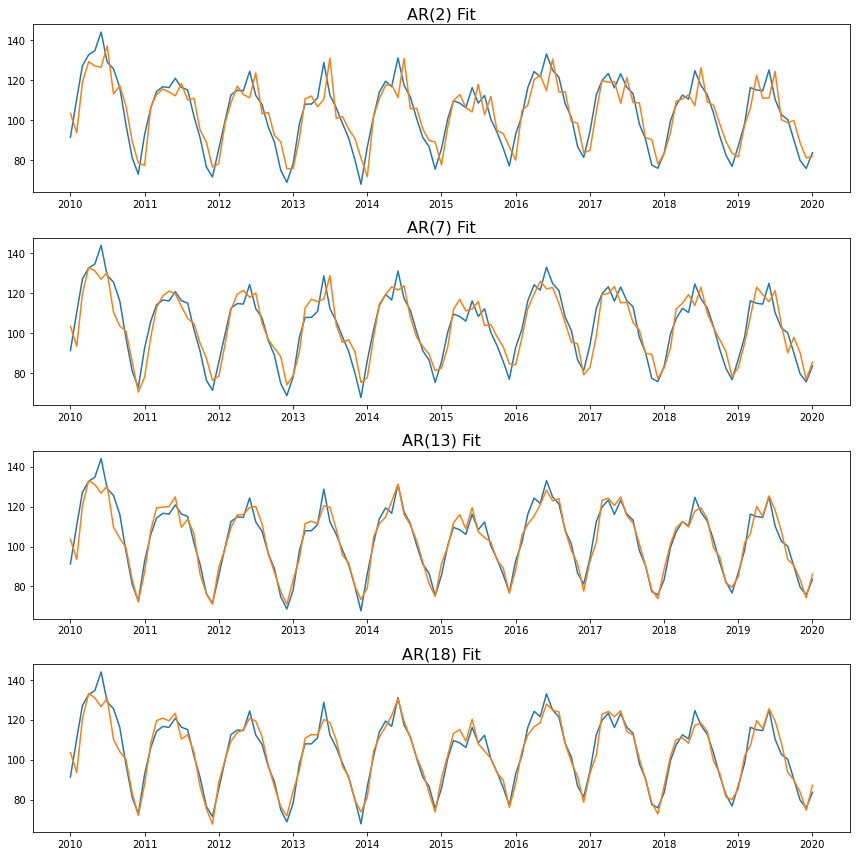

In [15]:
#AR Models
plt.figure(figsize=(12,12))
ar_orders = [2, 7, 13, 18]
ar_model_dict = {}

for idx, ar_order in enumerate(ar_orders):
    
    #create AR(p) model
    ar_model = ARIMA(ice_cream, order=(ar_order,0,0))
    ar_model_fit = ar_model.fit()
    ar_model_dict[ar_order] = ar_model_fit
    
    plt.subplot(len(ar_orders),1,idx+1)
    plt.plot(ice_cream)
    plt.plot(ar_model_fit.fittedvalues)
    plt.title(f'AR({ar_order}) Fit', fontsize=16)

plt.tight_layout()

In [16]:
for ar_order in ar_orders:
    print(f'AIC for AR({ar_order}): {ar_model_dict[ar_order].aic}')

AIC for AR(2): 865.4566445247774
AIC for AR(7): 829.9783079845269
AIC for AR(13): 730.1072998569314
AIC for AR(18): 732.7119920998823


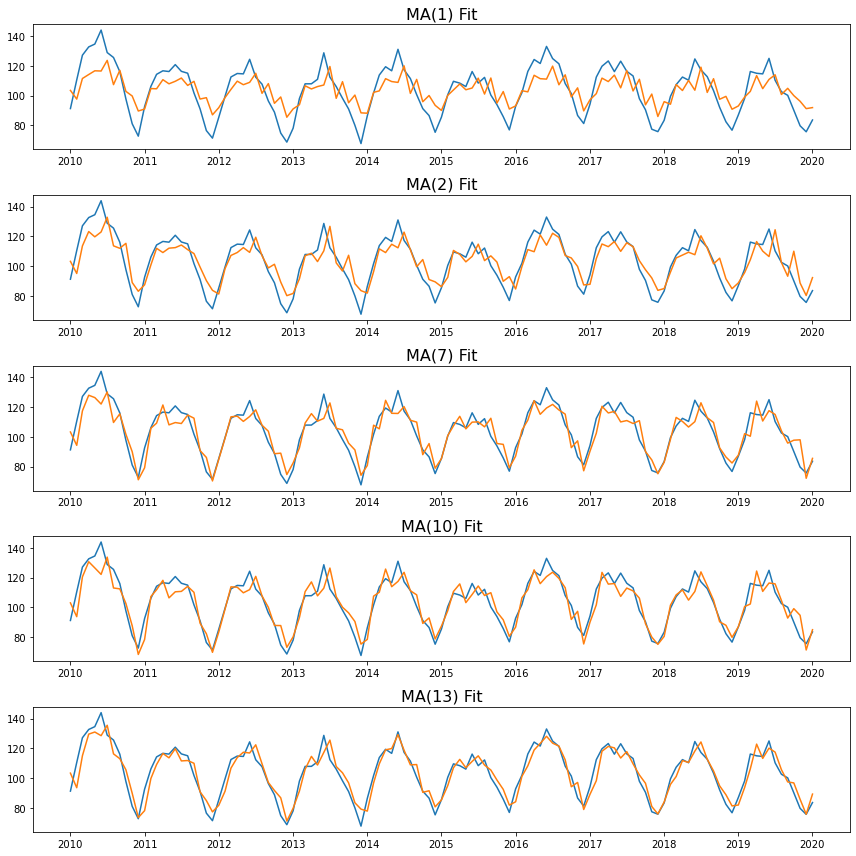

In [17]:
plt.figure(figsize=(12,12))
ma_orders = [1, 2, 7, 10, 13]
ma_model_dict = {}

for idx, ma_order in enumerate(ma_orders):
    
    #create MA(q) model
    ma_model = ARIMA(ice_cream, order=(0,0,ma_order),enforce_invertibility=False)
    ma_model_fit = ma_model.fit()
    ma_model_dict[ma_order] = ma_model_fit
    
    plt.subplot(len(ma_orders), 1,idx+1)
    plt.plot(ice_cream)
    plt.plot(ma_model_fit.fittedvalues)
    plt.title(f'MA({ma_order}) Fit', fontsize=16)

plt.tight_layout()

In [18]:
for ma_order in ma_orders:
    print(f'AIC for MA({ma_order}): {ma_model_dict[ma_order].aic}')

AIC for MA(1): 938.5460846699152
AIC for MA(2): 884.9802858772875
AIC for MA(7): 841.2082866507153
AIC for MA(10): 836.3326301104967
AIC for MA(13): 805.2063779538619


# Using the Best of AR and MA with ARIMA
Since the best AIC scores for AR & MA were order 13 we will try out an ARIMA(13) model (technically an ARMA model since integration is not being used...) and compare it to the other models.

Text(0.5, 1.0, 'ARIMA(13,0,13) Fit')

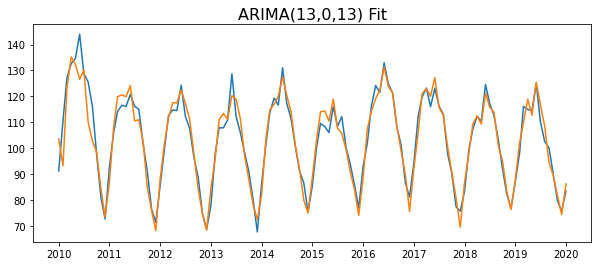

In [19]:
arima_model = ARIMA(ice_cream, order=(13,0,13),enforce_invertibility=False)
arima_model_fit = arima_model.fit()

plt.figure(figsize=(10,4))
plt.plot(ice_cream)
plt.plot(arima_model_fit.fittedvalues)
plt.title(f'ARIMA(13,0,13) Fit', fontsize=16)

In [20]:
print(f'AIC for ARIMA(13,0,13): {arima_model_fit.aic}')

AIC for ARIMA(13,0,13): 729.165578127443


# Using Summary for More In-Depth Details
The summary method in the statsmodels api is extremely insightful as it will show us which coefficients for AR and MA are actually valuable for the model. As you will see below, the model does not respond to MA at all and only has significant lags at 1, 12, & 13 for the AR model. It should also be noted that although the AIC *does* outperform the AR(13) model AIC score it does not have a better BIC score as shown in the summary for simpler AR(13) model shown further below:

In [21]:
#ARIMA(13,0,13)
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             production   No. Observations:                  121
Model:               ARIMA(13, 0, 13)   Log Likelihood                -336.583
Date:                Mon, 06 Sep 2021   AIC                            729.166
Time:                        16:53:35   BIC                            807.448
Sample:                    01-01-2010   HQIC                           760.959
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.6081      1.362     76.085      0.000     100.939     106.277
ar.L1          0.7990      0.232      3.443      0.001       0.344       1.254
ar.L2          0.0862      0.289      0.299      0.765      -0.480       0.652
ar.L3         -0.1417      0.208     -0.682      0.495      -0.549       0.265
ar.L4         -0.0438      0.234     -0.187      0.852      -0.503       0.416
ar.L5          0.1372      0.287      0.477      0.633      -0.426       0.701
ar.L6         -0.1654      0.217     -0.762      0.446      -0.591       0.260
ar.L7         -0.0417      0.257     -0.162      0.871      -0.546       0.462
ar.L8          0.1153      0.290      0.398      0.691      -0.453       0.684
ar.L9         -0.1288      0.210     -0.615      0.539      -0.540       0.282
ar.L10        -0.0461      0.231     -0.199      0.842      -0.499       0.406
ar.L11         0.1031      0.285      0.362      0.717      -0.455       0.661
ar.L12         0.8464      0.213      3.977      0.000       0.429       1.263
ar.L13        -0.8109      0.139     -5.850      0.000      -1.083      -0.539
ma.L1         -0.1690      1.604     -0.105      0.916      -3.312       2.974
ma.L2         -0.1001      0.816     -0.123      0.902      -1.699       1.499
ma.L3          0.1223      0.339      0.361      0.718      -0.542       0.786
ma.L4          0.1527      0.708      0.216      0.829      -1.235       1.540
ma.L5         -0.0581      0.882     -0.066      0.948      -1.787       1.671
ma.L6          0.1798      1.389      0.129      0.897      -2.543       2.903
ma.L7          0.0774      1.129      0.069      0.945      -2.136       2.291
ma.L8          0.0189      0.740      0.026      0.980      -1.432       1.470
ma.L9          0.2416      0.513      0.471      0.638      -0.764       1.248
ma.L10         0.1446      0.501      0.289      0.773      -0.837       1.126
ma.L11        -0.0318      1.090     -0.029      0.977      -2.168       2.105
ma.L12        -0.6513      0.975     -0.668      0.504      -2.562       1.259
ma.L13         0.1268      0.378      0.336      0.737      -0.614       0.868
sigma2        12.1129     22.091      0.548      0.583     -31.184      55.410
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.63
Prob(Q):                              0.98   Prob(JB):                         0.16
Heteroskedasticity (H):               0.82   Skew:                             0.37
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
#AR(13)
ar13_model = ARIMA(ice_cream, order=(13,0,0),enforce_invertibility=False)
ar13_model_fit = ar13_model.fit()
ar13_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             production   No. Observations:                  121
Model:                ARIMA(13, 0, 0)   Log Likelihood                -350.054
Date:                Mon, 06 Sep 2021   AIC                            730.107
Time:                        16:53:36   BIC                            772.044
Sample:                    01-01-2010   HQIC                           747.139
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5936      1.611     64.324      0.000     100.437     106.750
ar.L1          0.8425      0.071     11.935      0.000       0.704       0.981
ar.L2          0.0166      0.097      0.172      0.863      -0.173       0.206
ar.L3         -0.1071      0.094     -1.137      0.256      -0.292       0.078
ar.L4         -0.0174      0.101     -0.172      0.863      -0.216       0.181
ar.L5          0.0663      0.111      0.599      0.549      -0.151       0.283
ar.L6         -0.1535      0.091     -1.685      0.092      -0.332       0.025
ar.L7          0.0360      0.101      0.356      0.722      -0.162       0.234
ar.L8          0.0232      0.108      0.216      0.829      -0.188       0.234
ar.L9         -0.0887      0.091     -0.977      0.329      -0.267       0.089
ar.L10        -0.0045      0.081     -0.055      0.956      -0.164       0.155
ar.L11         0.0948      0.100      0.950      0.342      -0.101       0.290
ar.L12         0.7108      0.097      7.309      0.000       0.520       0.901
ar.L13        -0.6884      0.073     -9.373      0.000      -0.832      -0.544
sigma2        16.6176      2.784      5.969      0.000      11.161      22.074
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                 5.83
Prob(Q):                              0.25   Prob(JB):                         0.05
Heteroskedasticity (H):               0.91   Skew:                             0.53
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Analyzing the Results
Our two best contenders for the best model are between the ARMA(13,13) model and the simpler AR(13). The AIC results for both of these models are near identical with the tie breaker being the BIC score which informs us more on how well these models describe the true underlying function. Given that the AR(13) model performed better on its BIC score we should implement the AR(13) model over the ARMA(13,13) model. 

In [54]:
y_test = ice_cream.production[-12:]

In [55]:
predictions = ar13_model_fit.predict(params=y_test)[-12:]

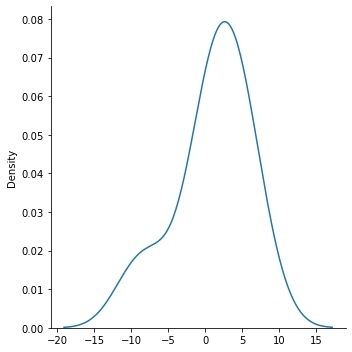

In [56]:
residuals = predictions - y_test
sns.displot(data=residuals,kind='kde')

In [57]:
from sklearn import metrics
import numpy as np

MAE = metrics.mean_absolute_error(y_test,predictions)
MAPE = metrics.mean_absolute_percentage_error(y_test,predictions) * 100
MSE = metrics.mean_squared_error(y_test,predictions)
RMSE = np.sqrt(metrics.mean_squared_error(y_test,predictions))
MedAE = metrics.median_absolute_error(y_test,predictions)
MedAPE = np.median((np.abs(np.subtract(y_test, predictions)/ y_test))) * 100

In [58]:
print('MAE:', np.round(MAE,2))
print('MAPE:', np.round(MAPE,2),'%')
print('MSE:', np.round(MSE,2))
print('RMSE:', np.round(RMSE,2))
print('MedAE:', np.round(MedAE,2))
print('MedAPE:',np.round(MedAPE,2),'%')

MAE: 3.94
MAPE: 3.86 %
MSE: 24.34
RMSE: 4.93
MedAE: 3.78
MedAPE: 4.09 %
